In [2]:
import nfl_data_py as nfl
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sn

# Introduction to Machine Learning: Supervised Learning

## Introduction and Problem Description

Welcome to my final project for DTSA-5509! Before running this notebook, please ensure you have all required dependancies installed in your build. All required packages are listed above. Also if you intend to run this notebook, ensure to place the folder extracted from the data source called "Rice_Images_Dataset" containing the image data into a fresh directory called "data", and set your local directory to contain "data". As a note, the dataset is reasonably large (~1 GB), so download may take a while. Thanks for taking the time to grade my work!

For this project I wanted to do machine learning models on fantasy football data. 

I'll use two different ML models that we learned in this course:

A KNN Classifier

An AdaBoost Classifier

A Random Forest Classifier

In [3]:
weekly_nfl = nfl.import_weekly_data(years=[2023])
print(weekly_nfl.columns)

Downcasting floats.
Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_t

In [4]:
# Filter the data for Wide Receivers (WR)

wr_data = weekly_nfl[weekly_nfl['position'] == 'WR']

# Sort the data by 'fantasy_points_ppr' in descending order

sorted_wr_data = wr_data.sort_values(by='fantasy_points_ppr', ascending=False)

df = sorted_wr_data

# Display the first few rows of the sorted data

#print(sorted_wr_data.head())
# Select specific columns to display

columns_to_display = ['player_id', 'player_name', 'player_display_name', 'recent_team' , 'week', 'opponent_team', 'fantasy_points_ppr' , 'target_share' ,'targets', 'receptions', 'receiving_yards', 'receiving_epa', 'rushing_yards']

# Display the sorted data with selected columns
print(sorted_wr_data[columns_to_display].head(5))

# Optionally, adjust pandas display options for better readability
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set display width
pd.set_option('display.max_colwidth', 20)   # Set max column width

       player_id player_name player_display_name recent_team  week  \
3587  00-0036900     J.Chase       Ja'Marr Chase         CIN     5   
443   00-0031544    A.Cooper        Amari Cooper         CLE    16   
1895  00-0034827     D.Moore          D.J. Moore         CHI     5   
163   00-0030279     K.Allen        Keenan Allen         LAC     3   
773   00-0033040      T.Hill         Tyreek Hill         MIA     1   

     opponent_team  fantasy_points_ppr  target_share  targets  receptions  \
3587           ARI           52.200001      0.431818       19          15   
443            HOU           51.500000      0.348837       15          11   
1895           WAS           49.000000      0.400000       10           8   
163            MIN           45.459999      0.416667       20          18   
773            LAC           44.500000      0.340909       15          11   

      receiving_yards  receiving_epa  rushing_yards  
3587            192.0      17.092861            0.0  
443     

In [5]:
#This cell prints the features we will be using in the EDA, along with information about EDAdata. All other features in Rice_MSC_Dataset seem to be statistical calculations, which may not have 
## direct physical meaning (have to do with orientation on image?)

# List of columns to include
columns_to_include = [
    'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 'receptions', 'targets', 'receiving_yards',
    'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
    'wopr', 'special_teams_tds', 'fantasy_points', 'fantasy_points_ppr'
]

# Filter the DataFrame to include only the specified columns
filtered_df = df[columns_to_include]

# Generate and display the summary statistics
summary = filtered_df.describe().round(2)
print("Summary Statistics for Selected Columns:")
display(summary.style.set_table_attributes("style='display:inline'").set_caption("Summary Statistics"))

Summary Statistics for Selected Columns:


,carries,rushing_yards,rushing_tds,rushing_fumbles,rushing_fumbles_lost,rushing_first_downs,rushing_epa,receptions,targets,receiving_yards,receiving_tds,receiving_fumbles,receiving_fumbles_lost,receiving_air_yards,receiving_yards_after_catch,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
count,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,358.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2332.000000,2284.000000,2332.000000,2281.000000,2284.000000,2284.000000,2284.000000,2332.000000,2332.000000,2332.000000
mean,0.210000,1.260000,0.010000,0.000000,0.000000,0.070000,0.190000,2.960000,4.690000,37.380000,0.220000,0.040000,0.020000,50.390000,13.030000,1.740000,1.000000,0.010000,0.960000,0.150000,0.210000,0.370000,0.000000,5.260000,8.220000
std,0.570000,5.100000,0.100000,0.060000,0.020000,0.270000,1.240000,2.520000,3.470000,37.800000,0.470000,0.190000,0.140000,45.160000,16.880000,1.770000,3.980000,0.100000,2.760000,0.100000,0.170000,0.250000,0.070000,5.770000,7.800000
min,0.000000,-20.000000,0.000000,0.000000,0.000000,0.000000,-6.150000,0.000000,0.000000,-6.000000,0.000000,0.000000,0.000000,-13.000000,-4.000000,0.000000,-17.950000,0.000000,-0.230000,0.020000,-0.130000,-0.040000,0.000000,-2.000000,-1.100000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.580000,1.000000,2.000000,8.000000,0.000000,0.000000,0.000000,14.000000,1.000000,0.000000,-1.150000,0.000000,0.310000,0.060000,0.070000,0.150000,0.000000,1.000000,2.180000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.160000,2.000000,4.000000,26.000000,0.000000,0.000000,0.000000,40.000000,7.000000,1.000000,0.580000,0.000000,0.720000,0.120000,0.180000,0.310000,0.000000,3.200000,6.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.880000,4.000000,7.000000,54.000000,0.000000,0.000000,0.000000,73.000000,18.000000,3.000000,2.940000,0.000000,1.140000,0.210000,0.310000,0.530000,0.000000,7.800000,12.100000
max,5.000000,54.000000,1.000000,1.000000,1.000000,2.000000,4.500000,18.000000,21.000000,265.000000,3.000000,2.000000,2.000000,286.000000,145.000000,14.000000,23.630000,1.000000,116.000000,0.550000,1.200000,1.410000,1.000000,41.000000,52.200000


<Axes: >

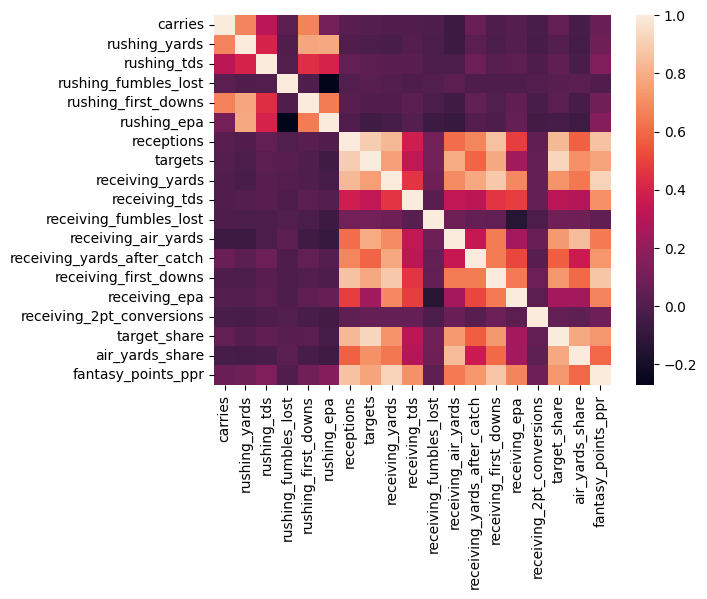

In [6]:
# List of columns you want to include in the cor3relation matrix
columns_to_include = [
    'carries',
    'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'target_share', 'air_yards_share',
    'fantasy_points_ppr'
]

# Select only the columns you want
selected_data = sorted_wr_data[columns_to_include]

# Filter out non-numeric columns
numeric_data = selected_data.select_dtypes(include=['number'])

# Create the correlation matrix
corrMatrix = numeric_data.corr()

sn.heatmap(corrMatrix)


## Matrix Analysis


1.    Strong Positive Correlations:

        - receptions and targets (0.90): This suggests that as the number of receptions increases, the number of targets also tends to increase, which is expected.
        
        - receiving_yards and fantasy_points_ppr (0.91): This indicates that higher receiving yards are strongly associated with higher fantasy points in PPR (points per reception) leagues.
        
        - fantasy_points and fantasy_points_ppr (0.97): This very high correlation is expected since both metrics are closely related, with PPR adding points for receptions.
        
3.    Moderate Positive Correlations:
        
        - rushing_yards and rushing_first_downs (0.78): More rushing yards are associated with more first downs, which makes sense in a football context.
        
        - receiving_yards and receiving_first_downs (0.87): More receiving yards are associated with more first downs.
  
4.    Weak or No Correlations:
        
        - rushing_yards and rushing_first_downs (0.78): More rushing yards are associated with more first downs, which makes sense in a football context.
        
        - rushing_fumbles and most other variables: The correlations are very low, indicating little to no linear relationship with other metrics.

        - special_teams_tds and most other variables: This metric shows very low correlation with others, suggesting it doesn't strongly relate to the other performance metrics.

6.    Negative Correlations:

        - rushing_epa and rushing_fumbles (-0.54): This suggests that more fumbles are associated with a lower expected points added (EPA) from rushing, which is logical as fumbles can negatively impact a team's performance.


## Pair Plot

Pair plot is a fast way to inspect relationships between features. Use seaborn's .pairplot() function to draw a pairplot if the first 10 columns (including price) and inspect their relationships. Set the diagonal elements to be KDE plot. The resulting plot will look like below.

In [ ]:
import seaborn as sns

# Create the pair plot
sns.pairplot(df[columns_to_include], diag_kind='kde')

# Show the plot
plt.show()


KeyboardInterrupt



## Splitting Fantasy Data into Training and Testing Sets

This guide demonstrates how to use the train_test_split function from the sklearn.model_selection module to divide your fantasy data into training and testing subsets. By splitting the data, you can train your machine learning models on one portion and evaluate their performance on another, ensuring a robust assessment of the model's predictive capabilities. The example provided uses an 80/20 split, but you can adjust the test_size parameter to suit your needs.

In [7]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame containing the fantasy data
# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Print the lengths of the training and testing sets
print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")

Length of X_train: 1865
Length of X_test: 467


## Train a simple linear regression model

This section demonstrates how to build and train a simple linear regression model using your fantasy data. The process involves splitting the data into training and testing sets, selecting a predictor, and evaluating the model's performance using the adjusted R-squared value.

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

# Assuming 'df' is your DataFrame containing the fantasy data
# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Define the best_guess_predictor (for example, let's use 'carries')
best_guess_predictor = 'target_share'

# Build and train the simple linear regression model
model = smf.ols(formula=f'fantasy_points ~ {best_guess_predictor}', data=X_train).fit()

# Print the result summary
print(model.summary())

# Update the adjusted R-squared value according to the result
adj_R2 = model.rsquared_adj
print(f"Adjusted R-squared value: {adj_R2:.4f}")

                            OLS Regression Results                            
Dep. Variable:         fantasy_points   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1197.
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          4.23e-202
Time:                        13:55:52   Log-Likelihood:                -5352.9
No. Observations:                1825   AIC:                         1.071e+04
Df Residuals:                    1823   BIC:                         1.072e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0127      0.188     -0.067   

## Best Predictor

In the last section we guessed what would be the best predictor, now we are going to test to see what the top 3 predictors actually are 

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer

# Assuming df is your DataFrame and it's already loaded

# Select a subset of predictors with minimal missing values
selected_predictors = ['carries',
    'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost',
    'rushing_first_downs', 'rushing_epa', 
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_fumbles_lost', 'receiving_air_yards',
    'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
    'receiving_2pt_conversions', 'target_share', 'air_yards_share']

# Impute missing values with the mean for the selected predictors
imputer = SimpleImputer(strategy='mean')
df[selected_predictors] = imputer.fit_transform(df[selected_predictors])

# Split the data into training and testing sets
X_train, X_test = train_test_split(df, test_size=0.2, random_state=42)

# Ensure the target variable is numeric
X_train['fantasy_points_ppr'] = pd.to_numeric(X_train['fantasy_points_ppr'], errors='coerce')

# Check if the dataset is empty after imputing missing values
if X_train.empty:
    print("The dataset is empty after imputing missing values. Please check your data.")
else:
    # Dictionary to store adjusted R-squared values
    adj_r2_values = {}

    # Fit a simple linear regression model for each selected predictor
    for predictor in selected_predictors:
        model = smf.ols(formula=f'fantasy_points_ppr ~ {predictor}', data=X_train).fit()
        adj_r2_values[predictor] = model.rsquared_adj

    # Convert the dictionary to a DataFrame for easier sorting
    adj_r2_df = pd.DataFrame(list(adj_r2_values.items()), columns=['Predictor', 'Adjusted R-squared'])

    # Sort the DataFrame by adjusted R-squared values in descending order
    adj_r2_df = adj_r2_df.sort_values(by='Adjusted R-squared', ascending=False)

    # Print the ranked list of all predictors
    print("Ranked list of selected predictors based on adjusted R-squared values:")
    print(adj_r2_df)

    # Print the top three predictors
    top_three_predictors = adj_r2_df.head(5)
    print("\nTop three predictors in order:")
    print(top_three_predictors)

    # Update the top_three list
    top_three = top_three_predictors['Predictor'].tolist()
    print("\nTop three predictors list:")
    print(top_three)

Ranked list of selected predictors based on adjusted R-squared values:
              Predictor  Adjusted R-squared
8       receiving_yards            0.851402
13  receiving_first_...            0.763862
6            receptions            0.750264
7               targets            0.600553
12  receiving_yards_...            0.530948
16         target_share            0.529301
9         receiving_tds            0.503312
14        receiving_epa            0.441861
11  receiving_air_yards            0.416634
17      air_yards_share            0.340036
2           rushing_tds            0.021139
15  receiving_2pt_co...            0.011426
4   rushing_first_downs            0.010095
5           rushing_epa            0.006621
1         rushing_yards            0.006145
10  receiving_fumble...            0.003912
0               carries            0.003004
3   rushing_fumbles_...           -0.000468

Top three predictors in order:
              Predictor  Adjusted R-squared
8       receiving

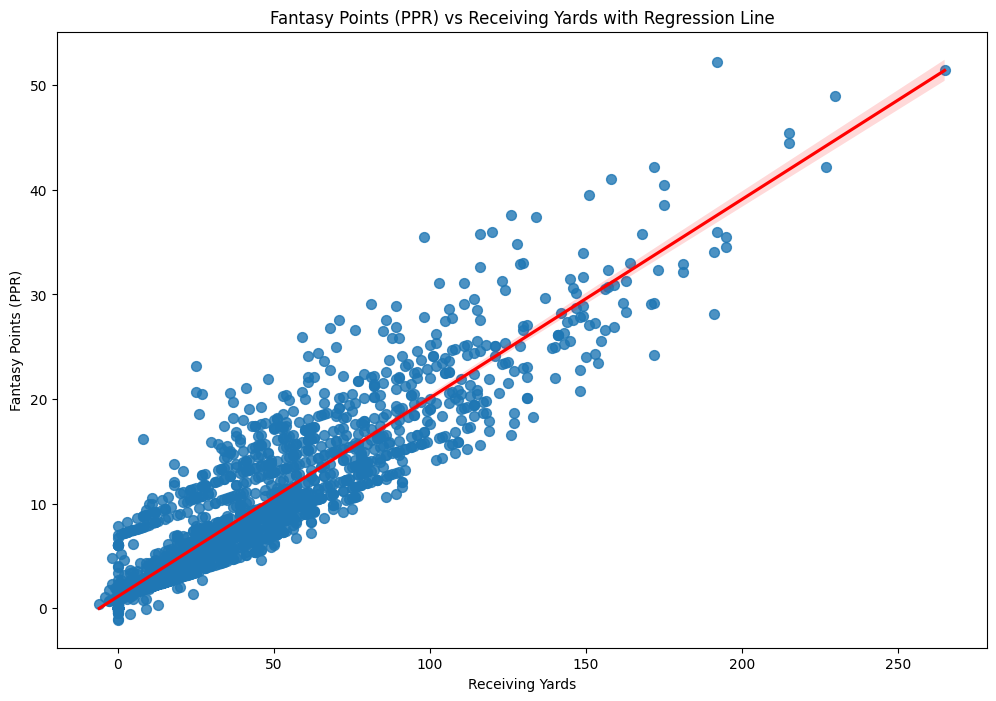

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame

# Plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='receiving_yards', y='fantasy_points_ppr', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Receiving Yards')
plt.ylabel('Fantasy Points (PPR)')
plt.title('Fantasy Points (PPR) vs Receiving Yards with Regression Line')

# Display the plot
plt.show()

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_10007/3151088898.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='receiving_first_downs_group', y='fantasy_points_ppr', data=df, palette='Set1')


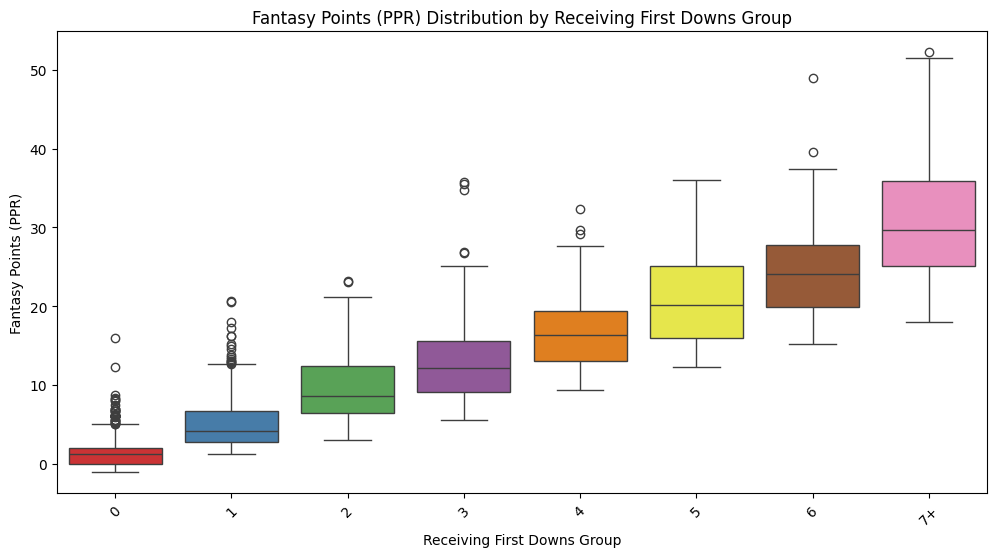

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame

# Create bins for receiving_first_downs
bins = [-1, 0, 1, 2, 3, 4, 5, 6, float('inf')]
labels = ['0', '1', '2', '3', '4', '5', '6', '7+']
df['receiving_first_downs_group'] = pd.cut(df['receiving_first_downs'], bins=bins, labels=labels, right=True)

# Plot the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='receiving_first_downs_group', y='fantasy_points_ppr', data=df, palette='Set1')
plt.title('Fantasy Points (PPR) Distribution by Receiving First Downs Group')
plt.xlabel('Receiving First Downs Group')
plt.ylabel('Fantasy Points (PPR)')
plt.xticks(rotation=45)
plt.show()

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_10007/900651058.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='receptions', data=df, palette='Set1')


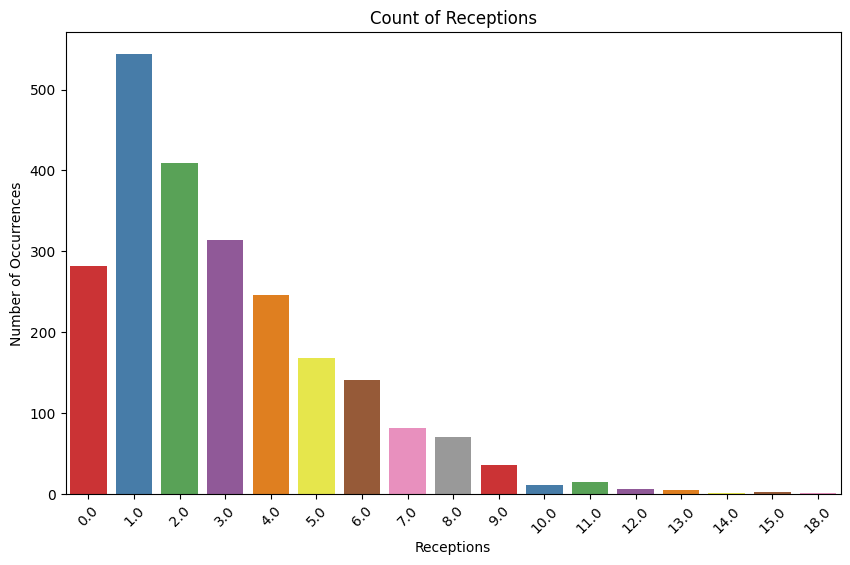

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.countplot(x='receptions', data=df, palette='Set1')
plt.title('Count of Receptions')
plt.xlabel('Receptions')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)
plt.show()

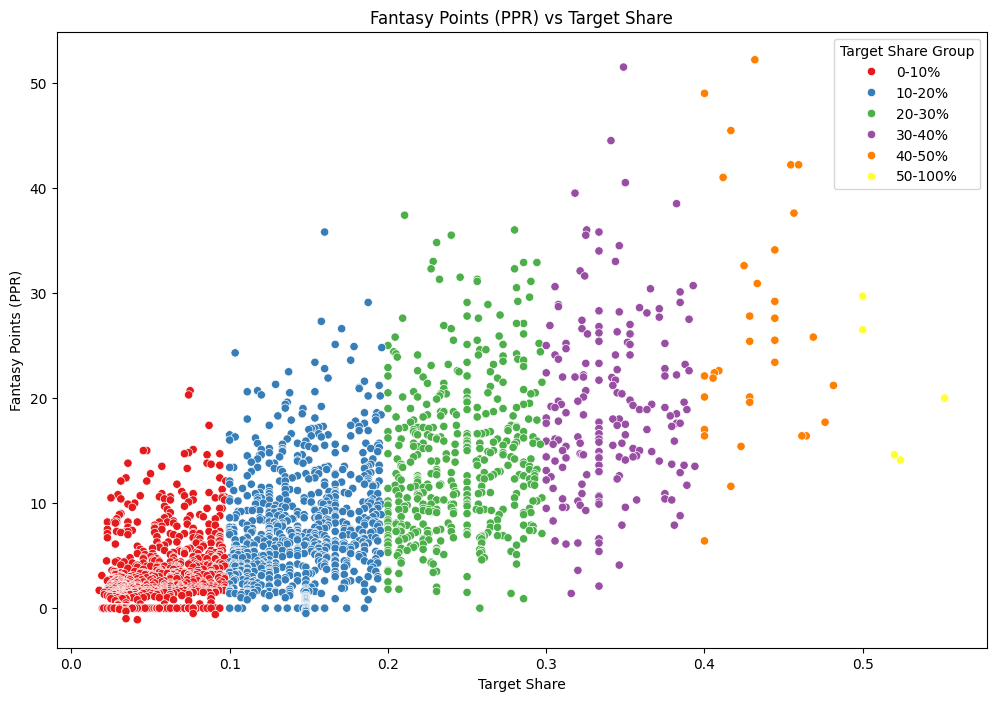

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a new column for target share categories
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-100%']
df['target_share_group'] = pd.cut(df['target_share'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='target_share', y='fantasy_points_ppr', hue='target_share_group', palette='Set1')
plt.title('Fantasy Points (PPR) vs Target Share')
plt.xlabel('Target Share')
plt.ylabel('Fantasy Points (PPR)')
plt.legend(title='Target Share Group')
plt.show()

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_10007/4288844298.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target_share_group', y='fantasy_points_ppr', data=df, palette='Set1')


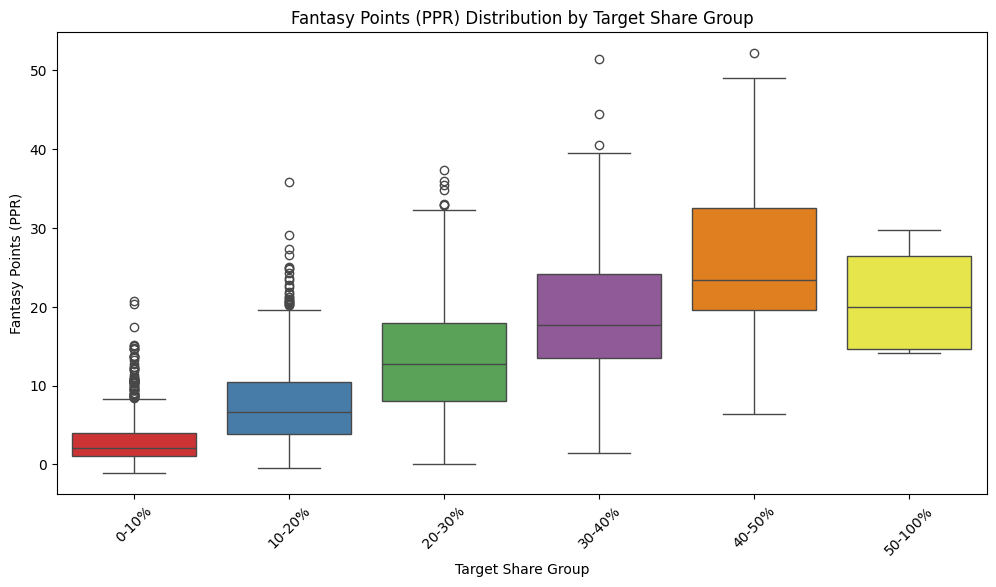

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame and 'target_share_group' is already created
plt.figure(figsize=(12, 6))
sns.boxplot(x='target_share_group', y='fantasy_points_ppr', data=df, palette='Set1')
plt.title('Fantasy Points (PPR) Distribution by Target Share Group')
plt.xlabel('Target Share Group')
plt.ylabel('Fantasy Points (PPR)')
plt.xticks(rotation=45)
plt.show()

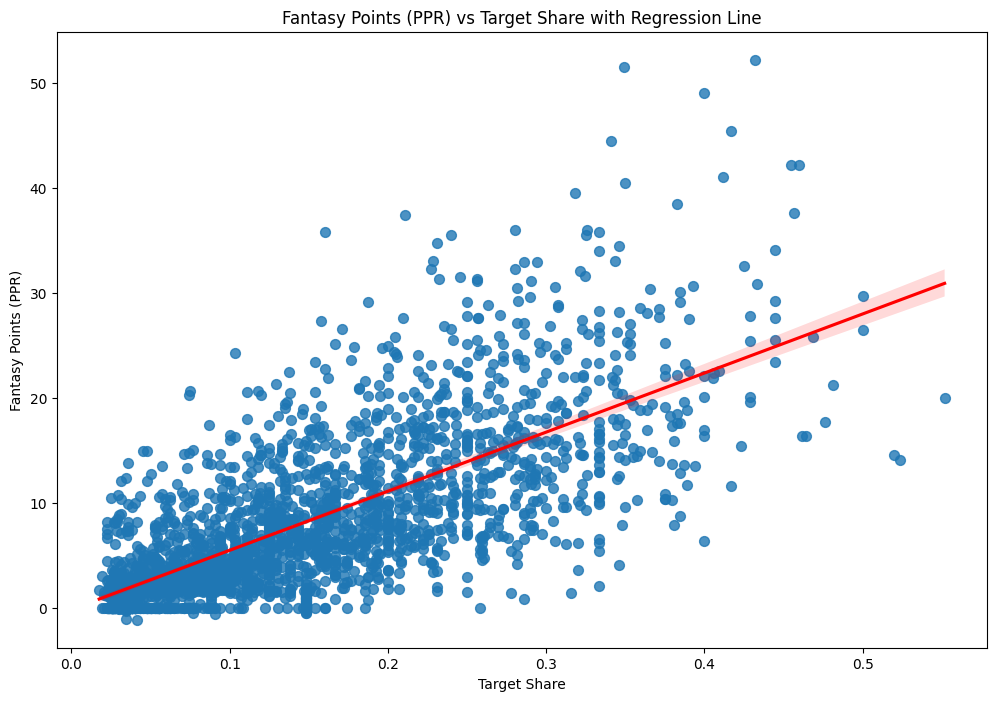

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'df' is your DataFrame
# Create a new column for target share categories
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-100%']
df['target_share_group'] = pd.cut(df['target_share'], bins=bins, labels=labels, right=False)

# Plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='target_share', y='fantasy_points_ppr', data=df, scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set plot labels and title
plt.xlabel('Target Share')
plt.ylabel('Fantasy Points (PPR)')
plt.title('Fantasy Points (PPR) vs Target Share with Regression Line')

# Display the plot
plt.show()

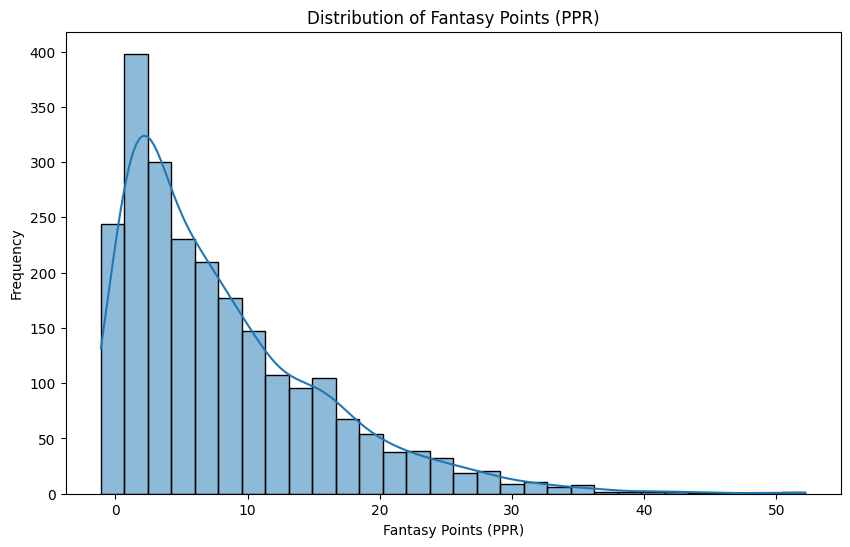

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10, 6))
sns.histplot(sorted_wr_data['fantasy_points_ppr'], bins=30, kde=True)
plt.title('Distribution of Fantasy Points (PPR)')
plt.xlabel('Fantasy Points (PPR)')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Group by player and calculate average statistics
player_aggregates = df.groupby('player_id').agg({
    'receptions': 'mean',
    'receiving_yards': 'mean',
    'receiving_tds': 'mean',
    'receiving_first_downs': 'mean',
    'targets': 'mean',
    'fantasy_points_ppr': ['mean', 'std']  # Calculate mean and standard deviation
}).reset_index()

# Rename columns for clarity
player_aggregates.columns = ['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                             'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points']



In [18]:
# Sort players by average fantasy points in descending order
player_aggregates = player_aggregates.sort_values(by='avg_fantasy_points', ascending=False)

# Select the top 80 players
top_80_players = player_aggregates.head(80)


# Reclassify performance within the top 80 players
top_80_players['performance_category'] = pd.qcut(top_80_players['avg_fantasy_points'], q=3, labels=['Low', 'Average', 'High'])

# Calculate confidence as the inverse of standard deviation
top_80_players['confidence'] = 1 / top_80_players['std_fantasy_points']

# Merge with original DataFrame to get player names
top_80_players = top_80_players.merge(df[['player_id', 'player_name']].drop_duplicates(), on='player_id')

# Display the list of players with confidence
#print(top_80_players[['player_name', 'avg_fantasy_points', 'performance_category', 'confidence']])

# Set pandas options to display more rows
pd.set_option('display.max_rows', 80)  # Adjust the number as needed

# Display the list of top 50 players with confidence
print(top_80_players[['player_name', 'avg_fantasy_points', 'performance_category', 'confidence', 'std_fantasy_points']])

       player_name  avg_fantasy_points performance_category  confidence  std_fantasy_points
0           C.Lamb           23.650002                 High    0.093768           10.664579
1           T.Hill           23.152941                 High    0.105362            9.491056
2          K.Allen           21.450768                 High    0.086152           11.607433
3      J.Jefferson           20.420000                 High    0.094896           10.537847
4      A.St. Brown           20.342106                 High    0.156506            6.389515
5          P.Nacua           18.411110                 High    0.106910            9.353696
6        N.Collins           17.305883                 High    0.094983           10.528145
7          A.Brown           17.035294                 High    0.097726           10.232665
8          D.Moore           16.852942                 High    0.085493           11.696854
9          M.Evans           16.789474                 High    0.112733         

/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_10007/1547121775.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_80_players['performance_category'] = pd.qcut(top_80_players['avg_fantasy_points'], q=3, labels=['Low', 'Average', 'High'])
/var/folders/20/0q6sw6955wj24161s7_yjxw40000gn/T/ipykernel_10007/1547121775.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_80_players['confidence'] = 1 / top_80_players['std_fantasy_points']


In [19]:
# Define a threshold for categorizing performance
threshold = player_aggregates['avg_fantasy_points'].mean()  # You can also use median or any other value

# Create the performance category based on the threshold
player_aggregates['performance_category'] = player_aggregates['avg_fantasy_points'].apply(
    lambda x: 'High' if x > threshold else 'Low'
)

# Now you can proceed with the rest of your code
target = player_aggregates['performance_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the k-NN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


NameError: name 'features' is not defined

In [30]:
# Check the columns in features
print("Features columns:", features.columns)

# Check if these columns exist in player_aggregates
missing_columns = [col for col in features.columns if col not in player_aggregates.columns]
if missing_columns:
    print("Missing columns in player_aggregates:", missing_columns)
else:
    print("All feature columns are present in player_aggregates.")

NameError: name 'features' is not defined

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test)
plt.title('Confusion Matrix')
plt.show()

NameError: name 'knn' is not defined

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

features.hist(bins=20, figsize=(12, 10))
plt.suptitle('Feature Distributions')
plt.show()

NameError: name 'features' is not defined

In [33]:
sns.pairplot(player_aggregates, hue='performance_category', vars=features.columns)
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

NameError: name 'features' is not defined

In [34]:
accuracies = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    accuracies.append(knn.score(X_test_scaled, y_test))

plt.plot(range(1, 21), accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

NameError: name 'KNeighborsClassifier' is not defined

In [35]:
# Initialize the k-NN classifier
knn = KNeighborsClassifier()

# Define the parameter grid to search over
param_to_try = {"n_neighbors": [i for i in range(1, 11)]}

# Set up the GridSearchCV
grid = GridSearchCV(estimator=knn, param_grid=param_to_try, n_jobs=-1, cv=5)  # cv=5 for 5-fold cross-validation

# Fit the grid search to the training data
grid.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Score:", grid.best_score_)

NameError: name 'KNeighborsClassifier' is not defined

In [36]:
# Extract the results from the grid search
KNN_results_dic = grid.cv_results_

# Convert the results to a DataFrame
KNN_results = pd.DataFrame(KNN_results_dic)

# Extract the number of neighbors and the corresponding mean test scores
n_neighbors = list(KNN_results["param_n_neighbors"])
mean_score = list(KNN_results["mean_test_score"])

# Plot the results
plt.plot(n_neighbors, mean_score, marker='o')
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Mean Cross-Validation Score")
plt.title("K vs. Mean Cross-Validation Score")
plt.grid(True)
plt.show()

NameError: name 'grid' is not defined

In [37]:
# Get the best k-NN estimator from the grid search
bestKNN = grid.best_estimator_

# Use the best estimator to make predictions on the test set
yhat = bestKNN.predict(X_test_scaled)

# Calculate the accuracy of the model
model_accuracy = accuracy_score(y_true=y_test, y_pred=yhat)

# Print the accuracy
print("Accuracy of the Best k-NN Estimator:", model_accuracy)

NameError: name 'grid' is not defined

In [38]:
#import new data for predicting 
weekly_nfl_2024 = nfl.import_weekly_data(years=[2024])
wr_data_2024 = weekly_nfl[weekly_nfl['position'] == 'WR']

# Group by player and calculate average statistics
player_aggregates_2024 = wr_data_2024.groupby('player_id').agg({
    'receptions': 'mean',
    'receiving_yards': 'mean',
    'receiving_tds': 'mean',
    'receiving_first_downs': 'mean',
    'targets': 'mean',
    'fantasy_points_ppr': ['mean', 'std']  # Calculate mean and standard deviation
}).reset_index()

# Rename columns for clarity
player_aggregates_2024.columns = ['player_id', 'avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                             'avg_receiving_first_downs', 'avg_targets', 'avg_fantasy_points', 'std_fantasy_points']

Downcasting floats.


In [39]:
# Assuming these were the original features used for training
original_features = ['avg_receptions', 'avg_receiving_yards', 'avg_receiving_tds', 
                     'avg_receiving_first_downs', 'avg_targets']

# Ensure player_aggregates_2024 has the same features as the training data
features_2024 = player_aggregates_2024[original_features]

# Scale the new data using the same scaler
new_data_scaled = scaler.transform(features_2024)

# Predict performance categories
predictions = knn.predict(new_data_scaled)

# Add predictions to the new data
player_aggregates_2024['predicted_performance'] = predictions

# If player names are in another DataFrame, merge them
# Assuming df contains player_id and player_name
player_aggregates_2024 = player_aggregates_2024.merge(df[['player_id', 'player_name']], on='player_id', how='left')

# Select players predicted to have 'High' performance
top_players = player_aggregates_2024[player_aggregates_2024['predicted_performance'] == 'High']

# Display the top players
print(top_players[['player_name', 'predicted_performance']])

NameError: name 'scaler' is not defined

In [40]:
# Assuming player_aggregates is your training DataFrame
X_train = player_aggregates[original_features]  # Use the same features as before
y_train = player_aggregates['avg_fantasy_points']  # Target variable

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split the data (optional, for validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize and train the model
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Optionally evaluate the model
# y_val_pred = regressor.predict(X_val)
# print("Validation RMSE:", mean_squared_error(y_val, y_val_pred, squared=False))

RandomForestRegressor(random_state=42)

In [42]:
# Use the same features for the new data
features_2024 = player_aggregates_2024[original_features]

# Predict fantasy scores
predicted_fantasy_scores = regressor.predict(features_2024)

# Add predictions to the new data
player_aggregates_2024['predicted_fantasy_score'] = predicted_fantasy_scores

# Sort the DataFrame by predicted fantasy score in descending order
sorted_players = player_aggregates_2024.sort_values(by='predicted_fantasy_score', ascending=False)

# Select the top 20 players
top_20_players = sorted_players.head(20)

# Display the top 20 players with their predicted fantasy scores
#print(top_20_players[['player_name', 'predicted_performance', 'predicted_fantasy_score']])

# Group by player_name and calculate the mean of predicted fantasy scores
grouped_players = player_aggregates_2024.groupby('player_name').agg({
    'predicted_fantasy_score': 'mean',
    'predicted_performance': 'first'  # Assuming performance is consistent for each player
}).reset_index()

# Sort the grouped DataFrame by predicted fantasy score in descending order
sorted_grouped_players = grouped_players.sort_values(by='predicted_fantasy_score', ascending=False)

# Select the top 20 players
top_20_grouped_players = sorted_grouped_players.head(20)

# Display the top 20 players with their predicted fantasy scores
print(top_20_grouped_players[['player_name', 'predicted_performance', 'predicted_fantasy_score']])

KeyError: 'player_name'

In [ ]:
print(df.columns)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Define the feature columns
feature_columns = [
    'receptions', 'targets', 'receiving_yards', 'receiving_tds',
    'receiving_air_yards', 'receiving_yards_after_catch', 'receiving_first_downs',
    'target_share', 'air_yards_share'
]

# Extract features and labels (ensure you have a target variable, e.g., 'performance')
X = df[feature_columns]
y = df['fantasy_points_ppr']  # Replace 'performance' with your actual target column

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predict performance categories using the trained KNN model
df['predicted_performance'] = knn.predict(X_test_scaled)

# Rank WRs based on predicted performance and select the top 5
top_5_wr = df.sort_values(by='predicted_performance', ascending=False).head(5)

# Display the top 5 WRs
print(top_5_wr[['player_name', 'predicted_performance']])

## KNN Classifier Analysis:

In general, k-NN classifiers can face challenges when the value of K is set too high. In high-dimensional data, this can lead to sparsity, and a large K may introduce noise into the model. To address this, I conducted a GridSearchCV with 5-fold cross-validation to optimize accuracy across a range of K values. The results, as plotted above, indicate that K = 6 was the optimal choice, achieving a mean cross-validation score of 0.988. The model with K = 6 returned a test accuracy of 0.953, which is a strong performance for a classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the base estimator
base_estimator = DecisionTreeClassifier(max_depth=1)

# Initialize the AdaBoost classifier with the correct parameter
ada_clf = AdaBoostClassifier(estimator=base_estimator)

# Define the parameter grid to search over
param_grid = {
    "n_estimators": [50, 100, 150],  # Number of boosting stages
    "learning_rate": [0.01, 0.1, 1.0]  # Learning rate
}

# Set up the GridSearchCV
grid = GridSearchCV(estimator=ada_clf, param_grid=param_grid, n_jobs=-1, cv=5)

# Fit the grid search to the training data
grid.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Score:", grid.best_score_)

# Extract the results from the grid search
ada_results_dic = grid.cv_results_

# Convert the results to a DataFrame
ada_results = pd.DataFrame(ada_results_dic)

# Get the best AdaBoost estimator from the grid search
best_ada = grid.best_estimator_

# Use the best estimator to make predictions on the test set
yhat_ada = best_ada.predict(X_test_scaled)

# Calculate the accuracy of the model
ada_accuracy = accuracy_score(y_true=y_test, y_pred=yhat_ada)

# Print the accuracy
print("Accuracy of the Best AdaBoost Estimator:", ada_accuracy)

In [ ]:
# Extract unique learning rates
learning_rates = ada_results["param_learning_rate"].unique()

# Plot the results for each learning rate
for lr in learning_rates:
    # Filter results for the current learning rate
    subset = ada_results[ada_results["param_learning_rate"] == lr]
    
    # Plot the mean test score against the number of estimators
    plt.plot(subset["param_n_estimators"], subset["mean_test_score"], marker='o', label=f"Learning Rate: {lr}")

plt.xlabel("Number of Estimators")
plt.ylabel("Mean Cross-Validation Score")
plt.title("Number of Estimators vs. Mean Cross-Validation Score")
plt.legend(title="Learning Rate")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Define the parameter grid to search over
param_grid = {
    "n_estimators": [50, 100, 150],  # Number of trees in the forest
    "max_depth": [None, 10, 20],    # Maximum depth of the tree
    "min_samples_split": [2, 5, 10], # Minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4]    # Minimum number of samples required to be at a leaf node
}

# Set up the GridSearchCV
grid = GridSearchCV(estimator=rf_clf, param_grid=param_grid, n_jobs=-1, cv=5, verbose=2)

# Fit the grid search to the training data
grid.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Score:", grid.best_score_)

# Get the best Random Forest estimator from the grid search
best_rf = grid.best_estimator_

# Use the best estimator to make predictions on the test set
yhat_rf = best_rf.predict(X_test)

# Calculate the accuracy of the model
rf_accuracy = accuracy_score(y_true=y_test, y_pred=yhat_rf)

# Print the accuracy
print("Accuracy of the Best Random Forest Estimator:", rf_accuracy)

# Print a detailed classification report
print("\nClassification Report:\n", classification_report(y_test, yhat_rf))

# Plotting the results
results = grid.cv_results_
mean_test_scores = results['mean_test_score']

# Reshape the scores to plot them
scores_matrix = mean_test_scores.reshape(len(param_grid['n_estimators']), len(param_grid['max_depth']), len(param_grid['min_samples_split']))

# Plot the mean test scores for different numbers of trees
for i, max_depth in enumerate(param_grid['max_depth']):
    plt.figure(figsize=(8, 6))
    for j, min_samples_split in enumerate(param_grid['min_samples_split']):
        plt.plot(param_grid['n_estimators'], scores_matrix[:, i, j], label=f'max_depth={max_depth}, min_samples_split={min_samples_split}')
    
    plt.title(f'Grid Search Mean Test Scores for max_depth={max_depth}')
    plt.xlabel('Number of Trees')
    plt.ylabel('Mean Cross-Validated Score')
    plt.legend()
    plt.grid(True)
    plt.show()